In [19]:
import torch
def tokenize_and_extract_entity_indices(sentences, tokenizer):
    input_ids = []
    attention_masks = []
    entity_start_positions = []
    entity_end_positions = []

    for sentence in sentences:
        encoded = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Flatten the tensors to remove batch dimension added by `return_tensors`
        input_ids.append(encoded['input_ids'].squeeze())
        attention_masks.append(encoded['attention_mask'].squeeze())

        # Find entity markers
        start_index = (encoded['input_ids'].squeeze() == tokenizer.convert_tokens_to_ids('[E]')).nonzero(as_tuple=True)[0]
        end_index = (encoded['input_ids'].squeeze() == tokenizer.convert_tokens_to_ids('[/E]')).nonzero(as_tuple=True)[0]

        # In case of no entity marker found, assign 0 as a default index
        entity_start_positions.append(start_index[0] if len(start_index) > 0 else torch.tensor(0))
        entity_end_positions.append(end_index[0] if len(end_index) > 0 else torch.tensor(0))

    return torch.stack(input_ids), torch.stack(attention_masks), torch.stack(entity_start_positions), torch.stack(entity_end_positions)


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
dataset = pd.read_csv(r'/home/shovan/Phd_Prelim/PTM/Datasets/Ubiq_training_data_Apr9.csv')
dataset.head()

train_dataset, val_dataset = train_test_split(dataset, test_size=0.1, random_state=42, stratify=dataset['Label'])

test_dataset = pd.read_csv(r'/home/shovan/Phd_Prelim/PTM/Datasets/ubiq_test_Apr9.csv')

print("Train shape:", train_dataset.shape)
print("Validation shape:", val_dataset.shape)
print("Test shape:", test_dataset.shape)

Train shape: (2003, 2)
Validation shape: (223, 2)
Test shape: (160, 2)


In [21]:
import re
import string
def noise_clean(sent):
    if not sent.endswith('.'):
        sent+='.'
    return sent

# Apply preprocessing
train_dataset["Sentence"] = train_dataset["Sentence"].apply(noise_clean)
val_dataset["Sentence"] = val_dataset["Sentence"].apply(noise_clean)
test_dataset["Sentence"] = test_dataset["Sentence"].apply(noise_clean)

In [22]:
train_labels_counts = train_dataset['Label'].value_counts()
print("Training Labels Distribution:")
print(train_labels_counts)

val_labels_counts = val_dataset['Label'].value_counts()
print("\nValidation Labels Distribution:")
print(val_labels_counts)

test_labels_counts = test_dataset['Label'].value_counts()
print("\nTest Labels Distribution:")
print(test_labels_counts)

Training Labels Distribution:
0    1237
1     766
Name: Label, dtype: int64

Validation Labels Distribution:
0    138
1     85
Name: Label, dtype: int64

Test Labels Distribution:
0    95
1    65
Name: Label, dtype: int64


In [23]:
train_dataset["num_words"] = train_dataset.Sentence.apply(lambda x: len(x.split()))
train_dataset.info()
print(train_dataset.num_words.max())

val_dataset["num_words"] = val_dataset.Sentence.apply(lambda x: len(x.split()))
val_dataset.info()
print(val_dataset.num_words.max())

test_dataset["num_words"] = test_dataset.Sentence.apply(lambda x: len(x.split()))
test_dataset.info()
print(test_dataset.num_words.max())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2003 entries, 935 to 947
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   2003 non-null   object
 1   Label      2003 non-null   int64 
 2   num_words  2003 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 62.6+ KB
58
<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 134 to 1377
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   223 non-null    object
 1   Label      223 non-null    int64 
 2   num_words  223 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.0+ KB
49
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   160 non-null    object
 1   Label      160 non-null    int64 
 2   num_words  160 non-null 

In [27]:
model_name = 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext'
import transformers
from torch.utils.data import Dataset, DataLoader
#torch.cuda.empty_cache()
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast
# Free up memory
torch.cuda.empty_cache()


tokenizer = BertTokenizerFast.from_pretrained(model_name)

tokenizer.add_tokens(['[E]', '[/E]'])
print(len(tokenizer.get_vocab()))

30524


In [29]:
bert = AutoModel.from_pretrained(model_name)

bert.resize_token_embeddings(len(tokenizer))
print(bert.config.vocab_size)

Some weights of the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


30524


In [30]:
# Example call for the train dataset
train_input_ids, train_attention_masks, train_start_positions, train_end_positions = tokenize_and_extract_entity_indices(train_dataset['Sentence'].tolist(), tokenizer)

# Similarly for validation and test datasets
val_input_ids, val_attention_masks, val_start_positions, val_end_positions = tokenize_and_extract_entity_indices(val_dataset['Sentence'].tolist(), tokenizer)
test_input_ids, test_attention_masks, test_start_positions, test_end_positions = tokenize_and_extract_entity_indices(test_dataset['Sentence'].tolist(), tokenizer)

# Now, define a custom dataset
class ProteinDataset(Dataset):
    def __init__(self, input_ids, masks, start_positions, end_positions, labels=None):
        self.input_ids = input_ids
        self.masks = masks
        self.start_positions = start_positions
        self.end_positions = end_positions
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        item = {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.masks[idx],
            'start_position': self.start_positions[idx],
            'end_position': self.end_positions[idx]
        }
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

batch_size = 16

train_labels = torch.tensor(train_dataset['Label'].tolist())
val_labels = torch.tensor(val_dataset['Label'].tolist())
test_labels = torch.tensor(test_dataset['Label'].tolist())

train_data = ProteinDataset(train_input_ids, train_attention_masks, train_start_positions, train_end_positions, train_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = ProteinDataset(val_input_ids, val_attention_masks, val_start_positions, val_end_positions, val_labels)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

test_data = ProteinDataset(test_input_ids, test_attention_masks, test_start_positions, test_end_positions, test_labels)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [31]:
for param in bert.parameters():
    param.requires_grad = True

In [33]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        # Updated to handle three times the embedding size due to concatenation of CLS and two entity token embeddings
        self.fc1 = nn.Linear(768 * 3, 256)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(256, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask, start_pos, end_pos):
        # Getting outputs from BERT
        outputs = self.bert(sent_id, attention_mask=mask)
        sequence_output = outputs.last_hidden_state

        # Extract the CLS token's embeddings
        cls_hs = sequence_output[:, 0, :]  # CLS token is the first token

        # Extract embeddings for start and end entity positions
        start_embeddings = sequence_output[torch.arange(sequence_output.size(0)), start_pos]
        end_embeddings = sequence_output[torch.arange(sequence_output.size(0)), end_pos]

        # Concatenate CLS and entity embeddings
        concatenated_embeddings = torch.cat((cls_hs, start_embeddings, end_embeddings), dim=1)

        # Passing through the classifier layers
        x = self.fc1(concatenated_embeddings)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)

        return x


In [34]:

device = torch.device('cuda:1')

model = BERT_Arch(bert)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5, weight_decay = 0.001)
#from transformers import AdamW
#optimizer = AdamW(model.parameters(), lr = 1e-5)

from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

import numpy as np
from sklearn.utils import class_weight

#compute the class weights
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(train_dataset['Label']), y=train_dataset['Label'])

print("Class Weights:",class_weights)

# converting list of class weights to a tensor
from cProfile import label

weights= torch.tensor(class_weights,dtype=torch.float)

# push to CPU
weights = weights.to(device)

# define the loss function
#cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy  = nn.CrossEntropyLoss(weight=weights)
# number of training epochs
epochs = 10

Class Weights: [0.80962005 1.30744125]


In [37]:
def train():
    model.train()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(train_loader):
        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(train_loader)))

        # Unpack the batch directly into the respective tensors and move them to the device
        sent_id = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        start_pos = batch['start_position'].to(device)
        end_pos = batch['end_position'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()
        ypred = model(sent_id, mask, start_pos, end_pos)
        loss = cross_entropy(ypred, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        ypred = ypred.detach().cpu().numpy()
        total_preds.append(ypred)

    avg_loss = total_loss / len(train_loader)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds



In [38]:
def evaluate(dataloader):
    print("\nEvaluating...")
    model.eval()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,} of {:>5,}.'.format(step, len(dataloader)))

        # Unpack the batch directly into the respective tensors and move them to the device
        sent_id = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        start_pos = batch['start_position'].to(device)
        end_pos = batch['end_position'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            preds = model(sent_id, mask, start_pos, end_pos)
            loss = cross_entropy(preds, labels)
            total_loss += loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(dataloader)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds


In [39]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate(val_loader)
    
    scheduler.step(valid_loss)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/home/shovan/Phd_Prelim/PTM/Weights/ep10_ubiq_entity_May10.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 10
Batch    50 of   126.
Batch   100 of   126.


AttributeError: 'str' object has no attribute 'to'

In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the best model
model.load_state_dict(torch.load('/home/shovan/Phd_Prelim/PTM/Weights/ep10_ubiq_sumo_nedd_com_apr26.pt'))

test_loss, test_preds = evaluate(test_loader)  # Pass the correct dataloader here

# Convert predictions to label indices
pred_labels = np.argmax(test_preds, axis=1)

# Compute metrics
test_accuracy = accuracy_score(test_dataset['Label'].to_numpy(), pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_dataset['Label'].to_numpy(), pred_labels, average='binary')

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')


Evaluating...
Test Accuracy: 0.9203
Precision: 0.9267
Recall: 0.9145
F1: 0.9205


In [14]:
import numpy as np

# Assuming `dataset_tst['Sentence']` is your texts and `dataset_tst['Label']` are your true labels
true_labels = test_dataset['Label'].to_numpy()
predicted_labels = pred_labels  # This is obtained from your code

# Find the indices where predicted and true labels differ
mismatches = np.where(predicted_labels != true_labels)[0]

# Extract the texts and their predicted and true labels for the mismatches
mismatched_texts = test_dataset['Sentence'].iloc[mismatches].values
mismatched_predictions = predicted_labels[mismatches]
mismatched_true_labels = true_labels[mismatches]

# Display the results or process them further as needed
for i, text in enumerate(mismatched_texts):
    print(f"Text: {text}")
    print(f"Predicted Label: {mismatched_predictions[i]}, True Label: {mismatched_true_labels[i]}\n")

# Depending on your dataset size and the number of mismatches, you might want to limit the number of outputs.


Text: We find that all three TRANSFERASES can direct the MODIFICATION of TFIIEbetaand TFIIF, and we identify a [E]PROTEIN[/E] of MODIFICATION in TFIIEbeta.
Predicted Label: 0, True Label: 1

Text: Increased affinity of [E]PROTEIN[/E] for CREB-binding protein (CBP) after CBP-induced MODIFICATION.
Predicted Label: 0, True Label: 1

Text: The results of transcriptional activation assays with [E]PROTEIN[/E] MODIFICATION site mutants suggested that MODIFICATION of c-Myb at each of these five sites synergistically enhances c-Myb activity.
Predicted Label: 0, True Label: 1

Text: These results uncover novel post-translational modifications of Max and suggest the potential regulation of specific [E]PROTEIN[/E] complexes by p300 and reversible MODIFICATION.
Predicted Label: 0, True Label: 1

Text: Here we demonstrate that the C/H2 domain of CBP, which is critical for the TRANSFERASE activity, also directly interacts with the [E]PROTEIN[/E] of c-Myb.
Predicted Label: 0, True Label: 1

Text: Here

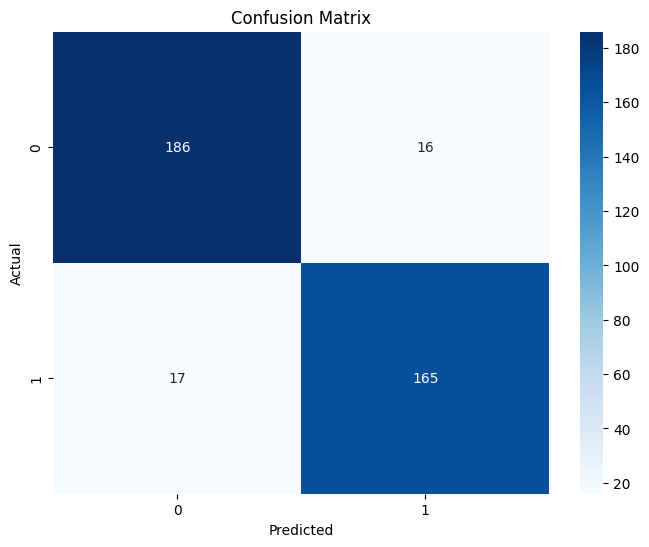

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# True labels
true_labels = test_dataset['Label'].to_numpy()

# Predicted labels
predicted_labels = pred_labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [28]:
def predict_sentences(sentences):
    # Tokenize the sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    
    # Move tensors to the correct device
    input_ids = encoded_input['input_ids'].to(device)
    attention_mask = encoded_input['attention_mask'].to(device)
    
    # Predict without using named arguments
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
    
    logits = outputs
    # Add a dimension to logits if it's missing the batch dimension
    if logits.dim() == 1:
        logits = logits.unsqueeze(0)
    predictions = torch.argmax(logits, dim=1)
    return predictions.cpu().numpy()

In [30]:
new_sentences = [
    "Moreover, [E]PROTEIN[/E] is neddylated in vivo, and ATGP-GROUP conjugates accumulate in cells lacking either Ubp3p or its cofactor, Bre5p."
]

predicted_classes = predict_sentences(new_sentences)
print("Predicted classes:", predicted_classes)

Predicted classes: [1]
